### Orientation detection by template matching
This whole experiment is conducted using only the original Bioniko eye phantom model with the Bioniko logo. After the limbus is detected we try to find the location of the logo along it and thus determine the orientation of the eye.

### 1. Imports

In [56]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

### 2. Helper constants and functions

In [57]:
bioniko_height_p = 0.15
bioniko_width_p = 0.14
bioniko_aspect = 5.7  # width/height
bioniko_font_factor = 1.35
base_limbus_center = (771, 763)
base_limbus_radius = 370
bioniko_source_limbus_center = (1031, 504)
bioniko_source_limbus_radius = 580
bioniko_source_text_start = 2010
bioniko_source_text_end = 2590

In [58]:
def linear_polar_norm(img: np.array, center: tuple, radius: int, flags=cv2.INTER_LINEAR) -> np.array:
    linear_polar = cv2.linearPolar(img, center, radius, flags)
    linear_polar = cv2.resize(linear_polar, (radius, round(2*np.pi*radius)))
    linear_polar = cv2.rotate(linear_polar, cv2.ROTATE_90_CLOCKWISE)

    return linear_polar

In [59]:
def write_bioniko(height: int, color: int = 0, background: int = 255) -> np.array:
    # Writes Bioniko logo to image in given height

    bioniko = background*np.ones((height, round(height*bioniko_aspect)))
    pil_im = Image.fromarray(bioniko)
    draw = ImageDraw.Draw(pil_im)
    font = ImageFont.truetype(
        'data/century-gothic-bold.ttf', size=round(height*bioniko_font_factor))
    draw.text((0, 0), 'BIONIKO', color, font=font, anchor='lt')
    bioniko = np.array(pil_im).astype('uint8')

    return bioniko

### 3. Generating base image with limbus detection

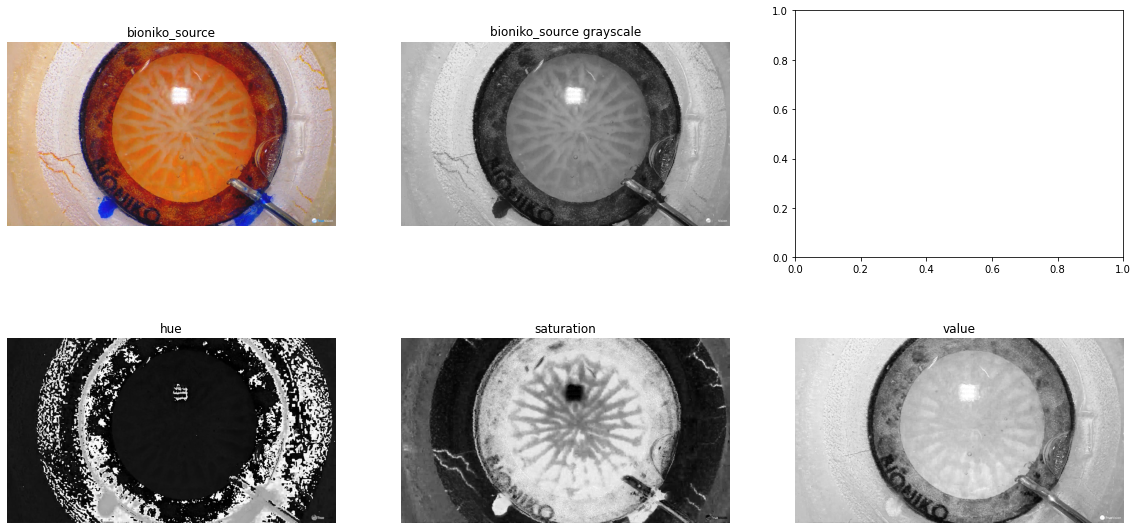

In [60]:
bioniko_source = cv2.imread(
    'data/artificial/bioniko_reference_source.png', cv2.IMREAD_COLOR)
bioniko_source_rgb = cv2.cvtColor(bioniko_source, cv2.COLOR_BGR2RGB)
bioniko_source_gray = cv2.cvtColor(bioniko_source, cv2.COLOR_BGR2GRAY)
bioniko_source_hsv = cv2.cvtColor(bioniko_source, cv2.COLOR_BGR2HSV)

bioniko_source_hue = bioniko_source_hsv[:, :, 0]
bioniko_source_saturation = bioniko_source_hsv[:, :, 1]
bioniko_source_value = bioniko_source_hsv[:, :, 2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)
      ) = plt.subplots(2, 3, figsize=(20, 10))
plot1.set_title('bioniko_source')
plot1.imshow(bioniko_source_rgb)
plot1.axis('off')

plot2.set_title('bioniko_source grayscale')
plot2.imshow(bioniko_source_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(bioniko_source_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(bioniko_source_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(bioniko_source_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

Creating limbus mask

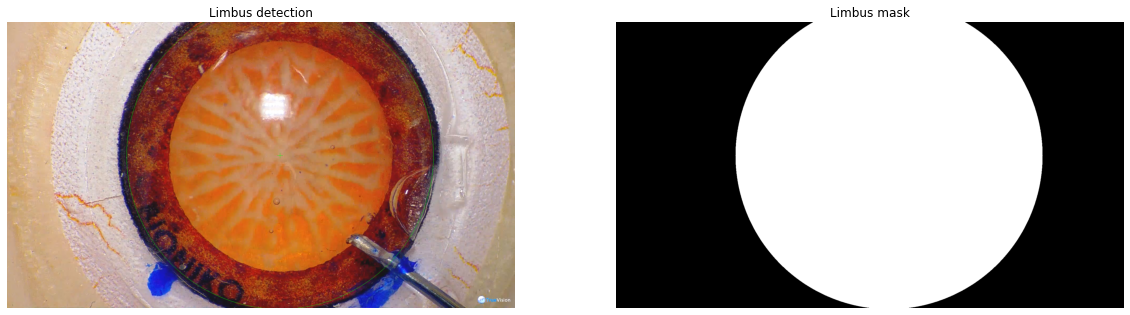

In [61]:
bioniko_source_limbus_mask = np.zeros(
    bioniko_source_value.shape, dtype=bioniko_source_value.dtype)
cv2.circle(bioniko_source_limbus_mask, bioniko_source_limbus_center,
           bioniko_source_limbus_radius, 255, cv2.FILLED)

bioniko_source_circles = bioniko_source_rgb.copy()
cv2.circle(bioniko_source_circles, bioniko_source_limbus_center,
           bioniko_source_limbus_radius, (0, 255, 0), 1)
cv2.drawMarker(bioniko_source_circles,
               bioniko_source_limbus_center, (0, 255, 0))

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 10))
plot1.set_title('Limbus detection')
plot1.imshow(bioniko_source_circles, cmap=plt.cm.gray)
plot1.axis('off')

plot2.set_title('Limbus mask')
plot2.imshow(bioniko_source_limbus_mask, cmap=plt.cm.gray)
plot2.axis('off')

plt.show()

### 4. Polar transform
Manual extraction of the Bioniko logo + polar transform of the iris and pupil in greyscale

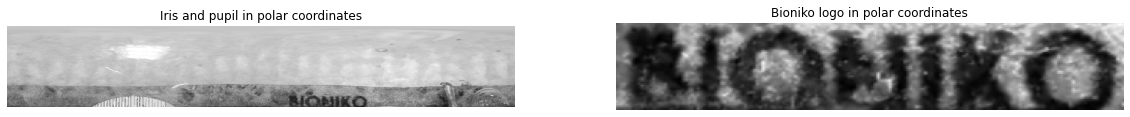

In [62]:
bioniko_source_polar = linear_polar_norm(
    bioniko_source_value,
    bioniko_source_limbus_center,
    bioniko_source_limbus_radius
)

bioniko_polar = bioniko_source_polar[
    round(bioniko_source_polar.shape[0]*(1 - bioniko_height_p)):,
    bioniko_source_text_start:bioniko_source_text_end
]

bioniko_polar = cv2.resize(
    bioniko_polar,
    (round(bioniko_width_p*base_polar.shape[1]),
     round(bioniko_height_p*base_polar.shape[0]))
)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 10))
plot1.set_title('Iris and pupil in polar coordinates')
plot1.imshow(bioniko_source_polar, cmap=plt.cm.gray)
plot1.axis('off')

plot2.set_title('Bioniko logo in polar coordinates')
plot2.imshow(bioniko_polar, cmap=plt.cm.gray)
plot2.axis('off')

plt.show()

### 5. Bioniko logo detection using the groundtruth
Various template matching methods from the OpenCV library are tried (see [docs](https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html))

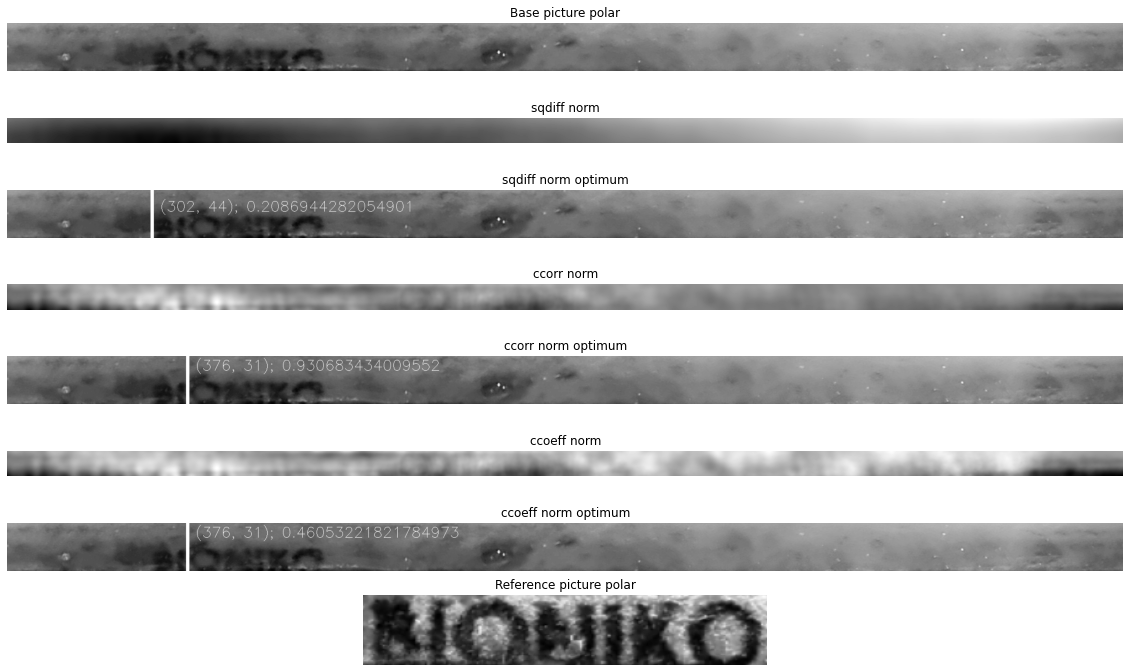

In [63]:
iris_polar = base_polar.copy()
iris_polar = iris_polar[270:, :]

matching_sqdiff_norm = cv2.matchTemplate(
    iris_polar, bioniko_polar, cv2.TM_SQDIFF_NORMED)
iris_polar_sqdiff_norm = iris_polar.copy()
matching_ccorr_norm = cv2.matchTemplate(
    iris_polar, bioniko_polar, cv2.TM_CCORR_NORMED)
iris_polar_ccorr_norm = iris_polar.copy()
matching_ccoeff_norm = cv2.matchTemplate(
    iris_polar, bioniko_polar, cv2.TM_CCOEFF_NORMED)
iris_polar_ccoeff_norm = iris_polar.copy()

min_val, _, min_loc, _ = cv2.minMaxLoc(matching_sqdiff_norm)
cv2.line(iris_polar_sqdiff_norm,
         (min_loc[0], 0), (min_loc[0], iris_polar.shape[0]-1), 255, 5)
cv2.putText(iris_polar_sqdiff_norm, ' %s; %s' %
            (min_loc, min_val), min_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
_, max_val, _, max_loc = cv2.minMaxLoc(matching_ccorr_norm)
cv2.line(iris_polar_ccorr_norm,
         (max_loc[0], 0), (max_loc[0], iris_polar.shape[0]-1), 255, 5)
cv2.putText(iris_polar_ccorr_norm, ' %s; %s' %
            (max_loc, max_val), max_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
_, max_val, _, max_loc = cv2.minMaxLoc(matching_ccoeff_norm)
cv2.line(iris_polar_ccoeff_norm,
         (max_loc[0], 0), (max_loc[0], iris_polar.shape[0]-1), 255, 5)
cv2.putText(iris_polar_ccoeff_norm, ' %s; %s' %
            (max_loc, max_val), max_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, 255)

fig, plots = plt.subplots(8, 1, figsize=(20, 12))
plots[0].set_title('Base picture polar')
plots[0].imshow(iris_polar, cmap=plt.cm.gray)
plots[0].axis('off')

plots[1].set_title('sqdiff norm')
plots[1].imshow(matching_sqdiff_norm, cmap=plt.cm.gray)
plots[1].axis('off')

plots[2].set_title('sqdiff norm optimum')
plots[2].imshow(iris_polar_sqdiff_norm, cmap=plt.cm.gray)
plots[2].axis('off')

plots[3].set_title('ccorr norm')
plots[3].imshow(matching_ccorr_norm, cmap=plt.cm.gray)
plots[3].axis('off')

plots[4].set_title('ccorr norm optimum')
plots[4].imshow(iris_polar_ccorr_norm, cmap=plt.cm.gray)
plots[4].axis('off')

plots[5].set_title('ccoeff norm')
plots[5].imshow(matching_ccoeff_norm, cmap=plt.cm.gray)
plots[5].axis('off')

plots[6].set_title('ccoeff norm optimum')
plots[6].imshow(iris_polar_ccoeff_norm, cmap=plt.cm.gray)
plots[6].axis('off')

plots[7].set_title('Reference picture polar')
plots[7].imshow(bioniko_polar, cmap=plt.cm.gray)
plots[7].axis('off')

plt.show()

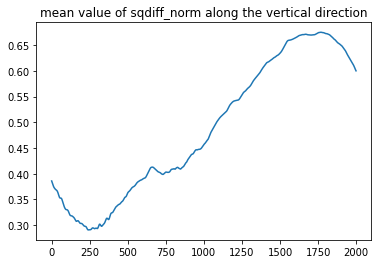

In [64]:
plt.title('mean value of sqdiff_norm along the vertical direction')
plt.plot(np.mean(matching_sqdiff_norm, axis=0))
plt.show()

### 6. Template matching using artificial Bioniko logo template

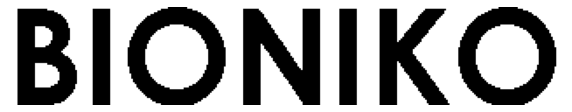

In [65]:
bioniko_polar_synth = write_bioniko(bioniko_polar.shape[0], background=100)

fig, plot1 = plt.subplots(1, 1, figsize=(10, 10))
plot1.imshow(bioniko_polar_synth, cmap=plt.cm.gray)
plot1.axis('off')

plt.show()

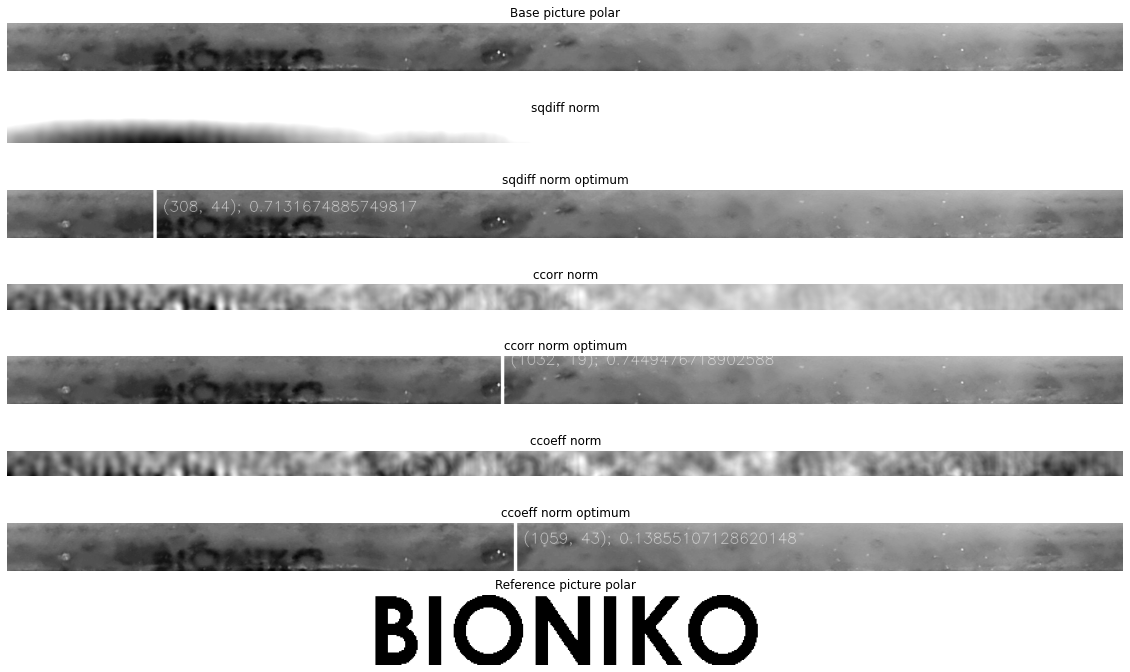

In [66]:
iris_polar = base_polar.copy()
iris_polar = iris_polar[270:, :]

matching_sqdiff_norm = cv2.matchTemplate(
    iris_polar, bioniko_polar_synth, cv2.TM_SQDIFF_NORMED)
iris_polar_sqdiff_norm = iris_polar.copy()
matching_ccorr_norm = cv2.matchTemplate(
    iris_polar, bioniko_polar_synth, cv2.TM_CCORR_NORMED)
iris_polar_ccorr_norm = iris_polar.copy()
matching_ccoeff_norm = cv2.matchTemplate(
    iris_polar, bioniko_polar_synth, cv2.TM_CCOEFF_NORMED)
iris_polar_ccoeff_norm = iris_polar.copy()

min_val, _, min_loc, _ = cv2.minMaxLoc(matching_sqdiff_norm)
cv2.line(iris_polar_sqdiff_norm,
         (min_loc[0], 0), (min_loc[0], iris_polar.shape[0]-1), 255, 5)
cv2.putText(iris_polar_sqdiff_norm, ' %s; %s' %
            (min_loc, min_val), min_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
_, max_val, _, max_loc = cv2.minMaxLoc(matching_ccorr_norm)
cv2.line(iris_polar_ccorr_norm,
         (max_loc[0], 0), (max_loc[0], iris_polar.shape[0]-1), 255, 5)
cv2.putText(iris_polar_ccorr_norm, ' %s; %s' %
            (max_loc, max_val), max_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
_, max_val, _, max_loc = cv2.minMaxLoc(matching_ccoeff_norm)
cv2.line(iris_polar_ccoeff_norm,
         (max_loc[0], 0), (max_loc[0], iris_polar.shape[0]-1), 255, 5)
cv2.putText(iris_polar_ccoeff_norm, ' %s; %s' %
            (max_loc, max_val), max_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, 255)

fig, plots = plt.subplots(8, 1, figsize=(20, 12))
plots[0].set_title('Base picture polar')
plots[0].imshow(iris_polar, cmap=plt.cm.gray)
plots[0].axis('off')

plots[1].set_title('sqdiff norm')
plots[1].imshow(matching_sqdiff_norm, cmap=plt.cm.gray)
plots[1].axis('off')

plots[2].set_title('sqdiff norm optimum')
plots[2].imshow(iris_polar_sqdiff_norm, cmap=plt.cm.gray)
plots[2].axis('off')

plots[3].set_title('ccorr norm')
plots[3].imshow(matching_ccorr_norm, cmap=plt.cm.gray)
plots[3].axis('off')

plots[4].set_title('ccorr norm optimum')
plots[4].imshow(iris_polar_ccorr_norm, cmap=plt.cm.gray)
plots[4].axis('off')

plots[5].set_title('ccoeff norm')
plots[5].imshow(matching_ccoeff_norm, cmap=plt.cm.gray)
plots[5].axis('off')

plots[6].set_title('ccoeff norm optimum')
plots[6].imshow(iris_polar_ccoeff_norm, cmap=plt.cm.gray)
plots[6].axis('off')

plots[7].set_title('Reference picture polar')
plots[7].imshow(bioniko_polar_synth, cmap=plt.cm.gray)
plots[7].axis('off')

plt.show()

Normalized Sum of Squared Difference seems to work the best.

### 7. Varying Bioniko logo template size

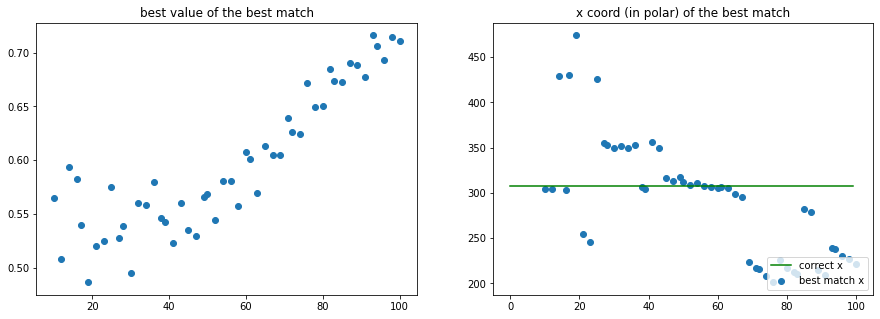

In [67]:
min_vals = []
min_locs = []

bioniko_sizes = np.round(np.linspace(0.1, 1)*iris_polar.shape[0]).astype('int')
for size in bioniko_sizes:
    bioniko_polar_synth = write_bioniko(size, background=120)
    matching_sqdiff_norm = cv2.matchTemplate(
        iris_polar, bioniko_polar_synth, cv2.TM_SQDIFF_NORMED)
    min_val, _, min_loc, _ = cv2.minMaxLoc(matching_sqdiff_norm)

    min_vals.append(min_val)
    min_locs.append(min_loc[0])

min_vals = np.array(min_vals)
min_locs = np.array(min_locs)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(15, 5))
plot1.set_title('best value of the best match')
plot1.scatter(bioniko_sizes, min_vals)

plot2.set_title('x coord (in polar) of the best match')
plot2.scatter(bioniko_sizes, min_locs, label='best match x')
plot2.plot(np.arange(max(bioniko_sizes)), [
           308]*max(bioniko_sizes), color='green', label='correct x')
plot2.legend(loc='lower right')

plt.show()